In [249]:
# Make a connection to Google drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth

In [250]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [251]:
# Import the required libraries
import torch
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
!pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-or0x0_os
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-or0x0_os


In [252]:
data_dir = "/content/drive/MyDrive/pathologyData.zip (Unzipped Files)/cancerData"

In [253]:
dataset = datasets.ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((100,100)),transforms.ToTensor()
]))

In [254]:
img, label = dataset[2999]
print(img.shape,label)

torch.Size([3, 100, 100]) 1


In [255]:
img, label = dataset[1499]
print(img.shape,label)

torch.Size([3, 100, 100]) 0


In [256]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

In [257]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [258]:
dataloader_train = DataLoader(
    train_dataset, batch_size=100, shuffle=True,
)

In [259]:
dataloader_test = DataLoader(
    test_dataset, batch_size=100, shuffle=True,
)

In [260]:
# Set seed

#Seed 1
torch.manual_seed(4)
random.seed(4)
np.random.seed(4)

#Seed 2
#torch.manual_seed(6)
#random.seed(6)
#np.random.seed(6)

#Seed 3
#torch.manual_seed(8)
#random.seed(8)
#np.random.seed(8)

torch.use_deterministic_algorithms(True)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=5000, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)
torch.Size([100, 3, 100, 100]) torch.Size([100]) torch.Size([100, 64])


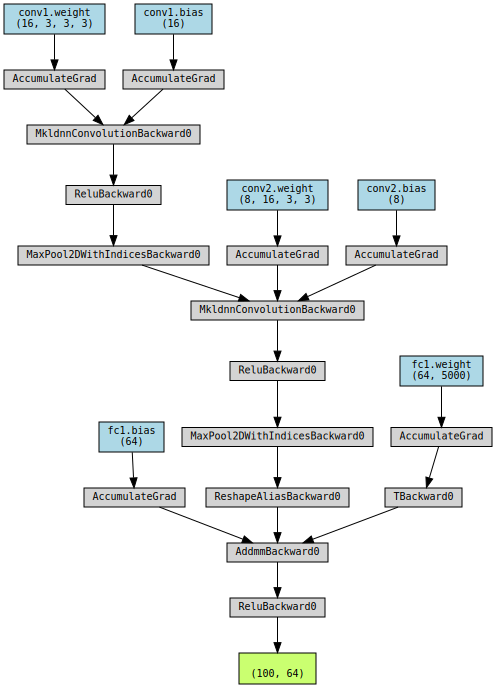

In [261]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # nn.Conv2d API : torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # 16 filters of 3x3 size and depth 3 (since input channel = 3(RGB))
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1) # 8 filters of 3X3 size and depth 16 #params = 8X3X3X16 + 
        
        # nn.Linear API : torch.nn.Linear(in_features, out_features, bias=True)
        self.fc1 = nn.Linear(25*25*8, 64)      #Dense Layer of 64 which as input params as 25*25*8
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        # BLOCK 1: CONV + RELU + MAXPOOL
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        # BLOCK 2: CONV  + RELU + MAXPOOL
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        # FLATTEN
        x = x.flatten(start_dim=1)
        # BLOCK 4: FC 
        x = F.relu(self.fc1(x))
        X = F.relu(self.fc2(x))
        return x

model = CNN()
print(model)
# get a random training batch
iterator = iter(dataloader_train)
X_batch, y_batch = next(iterator)
print(X_batch.shape, y_batch.shape, model(X_batch).shape)

# pass a batch through the model and visualize the architecture
# NOTE: we do not have to explicitly call model.forward(inputs), instead we just do model(inputs)
# This is because PyTorch internally takes care of, giving us this syntactic sugar
make_dot(model(X_batch), params=dict(model.named_parameters()))

In [262]:
def train(model, device, data_loader, optimizer, criterion, epoch):
    model.train()
    loss_train = 0
    num_correct = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
        prediction = output.argmax(dim=1)
        num_correct += prediction.eq(target).sum().item()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\tAccuracy: {:.0f}%'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss_train / (batch_idx + 1),
                100. * num_correct / (len(data) * (batch_idx + 1))))
    loss_train /= len(data_loader)
    accuracy = num_correct / len(data_loader.dataset)
    return loss_train, accuracy

In [263]:
def test(model, device, data_loader, criterion):
    model.eval()
    loss_test = 0
    num_correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            loss_test += loss.item()  # sum up batch loss
            prediction = output.argmax(dim=1)
            num_correct += prediction.eq(target).sum().item()
    loss_test /= len(data_loader)
    accuracy = num_correct / len(data_loader.dataset)
    return loss_test, accuracy

In [264]:
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001) #, betas=(0.9,0.999))

for epoch in range(1, 11):
    loss_train, acc_train = train(model, device, dataloader_train, optimizer, criterion, epoch)
    print('Epoch {} Train: Loss: {:.4f}, Accuracy: {:.3f}%\n'.format(
        epoch, loss_train, 100. * acc_train))
    loss_test, acc_test = test(model, device, dataloader_test, criterion)
    print('Epoch {} Test : Loss: {:.4f}, Accuracy: {:.3f}%\n'.format(
        epoch, loss_test, 100. * acc_test))

Train Epoch: 1 [0/2100 (0%)]	Loss: 4.1738	Accuracy: 0%
Epoch 1 Train: Loss: 3.1074, Accuracy: 48.000%

Epoch 1 Test : Loss: 2.8244, Accuracy: 50.444%

Train Epoch: 2 [0/2100 (0%)]	Loss: 2.7235	Accuracy: 52%
Epoch 2 Train: Loss: 2.6548, Accuracy: 49.810%

Epoch 2 Test : Loss: 2.4083, Accuracy: 50.444%

Train Epoch: 3 [0/2100 (0%)]	Loss: 2.4576	Accuracy: 49%
Epoch 3 Train: Loss: 2.2442, Accuracy: 49.810%

Epoch 3 Test : Loss: 2.1204, Accuracy: 50.444%

Train Epoch: 4 [0/2100 (0%)]	Loss: 2.0113	Accuracy: 53%
Epoch 4 Train: Loss: 1.1638, Accuracy: 61.429%

Epoch 4 Test : Loss: 0.2982, Accuracy: 88.222%

Train Epoch: 5 [0/2100 (0%)]	Loss: 0.2626	Accuracy: 88%
Epoch 5 Train: Loss: 0.1132, Accuracy: 99.095%

Epoch 5 Test : Loss: 0.0311, Accuracy: 99.667%

Train Epoch: 6 [0/2100 (0%)]	Loss: 0.0275	Accuracy: 100%
Epoch 6 Train: Loss: 0.0217, Accuracy: 99.952%

Epoch 6 Test : Loss: 0.0160, Accuracy: 99.778%

Train Epoch: 7 [0/2100 (0%)]	Loss: 0.0136	Accuracy: 100%
Epoch 7 Train: Loss: 0.0091, Ac